In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shap
import os
import shutil
import pickle

# Bibliothèques utiles pour la gestion des images
from PIL import Image, ImageOps 
from sklearn import preprocessing, cluster, metrics, manifold, decomposition
import cv2 as cv2
import time

#Pour utiliser CLIP d'OpenAI
import torch
import clip

# Importation et traitement des images

In [2]:
# Récupération dans un premier temps les infos du JSON
df_photos = pd.read_json('yelp_photos/photos.json', lines=True)
df_photos

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food
...,...,...,...,...
200095,4Zia9NkAfQNjMfcIDhwJ-g,2HxkdqHmbYGj_BH1bLaiSw,#Nektar,food
200096,KB96KRZRhRm8hUkI-OpGEA,_gVyuTRb_6HM-SNtqbpevQ,,inside
200097,Klmojvaf2_2dP1XKzTsFmQ,NUyEOjfAl3HvkpzSpdwqeA,,food
200098,FNEiq7Mogec7t31OaU5juw,hE6YsHHV0fCz_UrGS4o6VA,Drinks by the water!,drink


In [3]:
# On récupère seulement 200 images par catégories
# + Création des numéros de labels
df_photos_with_caption = df_photos[df_photos['caption'] != '']
df_photos_clean = df_photos_with_caption.groupby('label').head(200).reset_index(drop=True)
le = preprocessing.LabelEncoder()
df_photos_clean["num_label"] = le.fit_transform(df_photos_clean["label"])
df_photos_clean.groupby(['label'])['label'].count()

label
drink      200
food       200
inside     200
menu       200
outside    200
Name: label, dtype: int64

In [4]:
list_labels = ["drink", "food", "inside", "menu", "outside"]
df_photos_clean

,photo_id,business_id,caption,label,num_label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside,2
1,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink,0
2,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food,1
3,3ROd5PAQ_0OkmoKWVO06ag,u9vhzYtXpfyvAOAMnyy-Cw,Inside reception,inside,2
4,foJzmWwl8WlC3xi-QQDRgg,4OLfgjPToHrYf4HKXvlU2g,Small portion of the back patio,outside,4
...,...,...,...,...,...
995,EEcsawYOpKehTKchMnKPRA,-TCa3KBib07_1ko9L2Z0fQ,Funny sign at Yeomans cask and lion British pu...,menu,3
996,ASRHqFuyngOOdnxqfHSgpA,8Zfo-9ZQWwC85wyBcRDb_Q,Menu (Page 6 of 14),menu,3
997,YYlpq7j7rmYaiaTL5rHwLA,4zmaWmJx_24wjqE8px3uXA,Aunt Berta's Kitchen -- Menu 4,menu,3
998,GvZ7ErAAtVbJjVnrmXSpWQ,wGjD-JlJmqPuG5oTvxMKGg,Top 10 Drinks,menu,3


In [66]:
# On créer un dossier qui contient seulement les photos du dataset pour le mettre en tant que livrable pour la soutenance

# Chemin vers le dossier contenant les photos originales
dossier_original = 'yelp_photos/photos'

# Chemin vers le dossier où vous souhaitez stocker les photos filtrées
dossier_destination = 'photos_filtre'

ids = df_photos_clean['photo_id'].astype(str).tolist()  # Assurez-vous que la colonne s'appelle 'id' et convertissez en liste de chaînes

# Créer le dossier de destination s'il n'existe pas
if not os.path.exists(dossier_destination):
    os.makedirs(dossier_destination)

# Filtrer les photos
for fichier in os.listdir(dossier_original):
    # Supposons que les photos ont une extension .jpg et que le nom du fichier est l'ID
    id_photo = os.path.splitext(fichier)[0]
    if id_photo in ids:
        # Chemin complet vers la photo
        chemin_source = os.path.join(dossier_original, fichier)
        chemin_destination = os.path.join(dossier_destination, fichier)
        
        # Copier le fichier dans le dossier de destination
        shutil.copy(chemin_source, chemin_destination)

print("Filtrage terminé. Les photos sont copiées dans le dossier de destination.")


Filtrage terminé. Les photos sont copiées dans le dossier de destination.


In [5]:
# On re garde le nombre de photos qui ont une description vide 
nombre_valeurs_vides = (df_photos_clean['caption'] == '').sum()
print(f"Nombre de valeurs vides dans la colonne 'caption' du datframe avec les images : {nombre_valeurs_vides}")

Nombre de valeurs vides dans la colonne 'caption' du datframe avec les images : 0


### L'égalisation des histogrammes

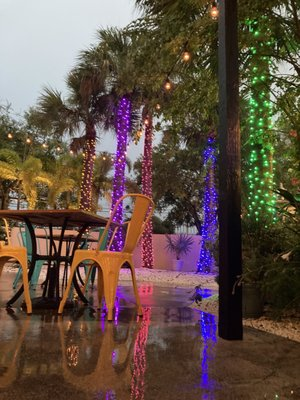

In [6]:
img1 = Image.open("yelp_photos/photos/"+df_photos_clean['photo_id'][4]+".jpg")
img1

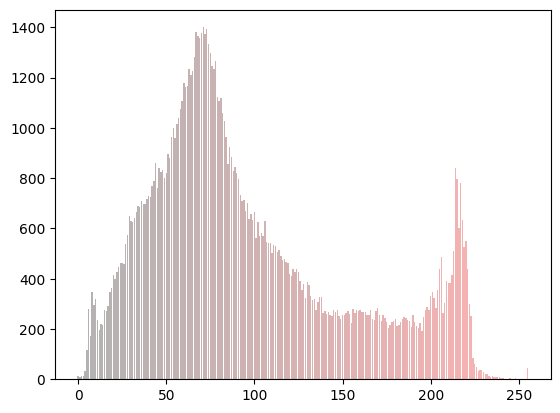

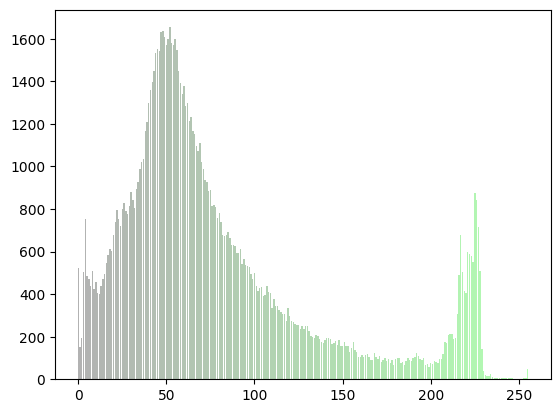

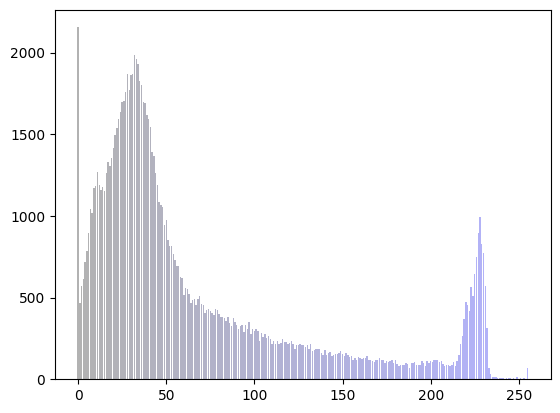

In [7]:
# On affiche les histogramme pour le RGB
def getRed(redVal):
    return '#%02x%02x%02x' % (redVal, 0, 0)
def getGreen(greenVal):
    return '#%02x%02x%02x' % (0, greenVal, 0)
def getBlue(blueVal):
    return '#%02x%02x%02x' % (0, 0, blueVal)

# Modify the color of two pixels
img1.putpixel((0,1), (1,1,5))
img1.putpixel((0,2), (2,1,5))

# Get the color histogram of the image
histogram = img1.histogram()

# Take only the Red counts
l1 = histogram[0:256]

# Take only the Blue counts
l2 = histogram[256:512]

# Take only the Green counts
l3 = histogram[512:768]

plt.figure(0)

for i in range(0, 256):
    plt.bar(i, l1[i], color = getRed(i),alpha=0.3)
plt.figure(1)             # plots a figure to display GREEN Histogram
for i in range(0, 256):
    plt.bar(i, l2[i], color = getGreen(i),alpha=0.3)
plt.figure(2)             # plots a figure to display BLUE Histogram
for i in range(0, 256):
    plt.bar(i, l3[i], color = getBlue(i),alpha=0.3)
plt.show()

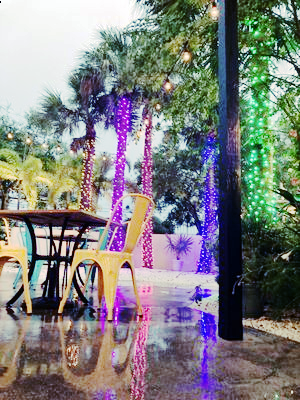

In [8]:
# Application de l'égalisation des histogrammes
img2 = ImageOps.equalize(img1, mask = None)
  
img2 

# Extraction des features par SIFT

## Détermination et affichage des descripteurs SIFT

* L'image contient 682 descripteurs
* Chaque descripteur est un vecteur de longueur 128

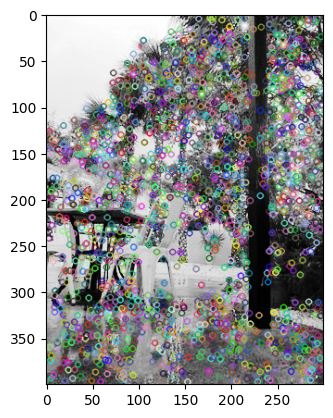

Descripteurs :  (1809, 128)

[[ 37.  20.  45. ...   8.   0.   0.]
 [  0.   0.   0. ...   0.   1. 131.]
 [ 13.  39. 114. ...   0.   0.   0.]
 ...
 [ 16.   7.   5. ...   0.   0.   0.]
 [ 91. 136.  45. ...   0.   0.   0.]
 [  7.   0.   0. ...   0.   8.  16.]]


In [9]:
# Charger l'image en niveaux de gris
image_path = "yelp_photos/photos/" + df_photos_clean['photo_id'][4] + ".jpg"
image = cv2.imread(image_path, 0)  # Convertir en niveaux de gris
image = cv2.equalizeHist(image)   # Égaliser l'histogramme de l'image

# Créer un objet SIFT
sift = cv2.SIFT_create()

# Détecter et calculer les descripteurs
kp, des = sift.detectAndCompute(image, None)

# Dessiner les keypoints sur l'image
img_with_keypoints = cv2.drawKeypoints(image, kp, None)

# Afficher l'image avec les keypoints
plt.imshow(img_with_keypoints)
plt.show()

# Afficher les informations sur les descripteurs
print("Descripteurs : ", des.shape)
print()
print(des)

## Pré-traitement des images via SIFT

## Créations des descripteurs de chaque image
* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteur

In [10]:
sift_keypoints = []
temps1=time.time()
# Créer un objet SIFT
sift = cv2.SIFT_create(nfeatures=500)

for image_num in range(len(df_photos_clean['photo_id'])) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread("yelp_photos/photos/"+df_photos_clean['photo_id'][image_num]+".jpg",0) # convert in gray
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints, dtype='object')
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900

Nombre de descripteurs :  (490624, 128)
temps de traitement SIFT descriptor :            28.71 secondes


## Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [11]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  700
Création de 700 clusters de descripteurs ...
temps de traitement kmeans :             6.26 secondes


## Création des features des images
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image
   
Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [12]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
temps de création histogrammes :             2.17 secondes


## Réductions de dimension

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [13]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1000, 700)
Dimensions dataset après réduction PCA :  (1000, 541)


### Réduction de dimension T-SNE
* Réduction de dimension en 3 composantes T-SNE pour affichage en 2D et 3D des images

In [14]:
tsne = manifold.TSNE(n_components=3, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:3], columns=['tsne1', 'tsne2', 'tsne3'])
df_tsne["class"] = df_photos_clean["label"]
df_tsne.to_csv('df_tsne_sift.csv', index=False)
print(df_tsne.shape)

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


(1000, 4)


## Analyse visuelle : affichage T-SNE selon catégories d'images
* On observe que les différentes catégories sont assez peu séparées
* Seulement les points de la catégories "menu" se retoruve un peu séparés des autres points

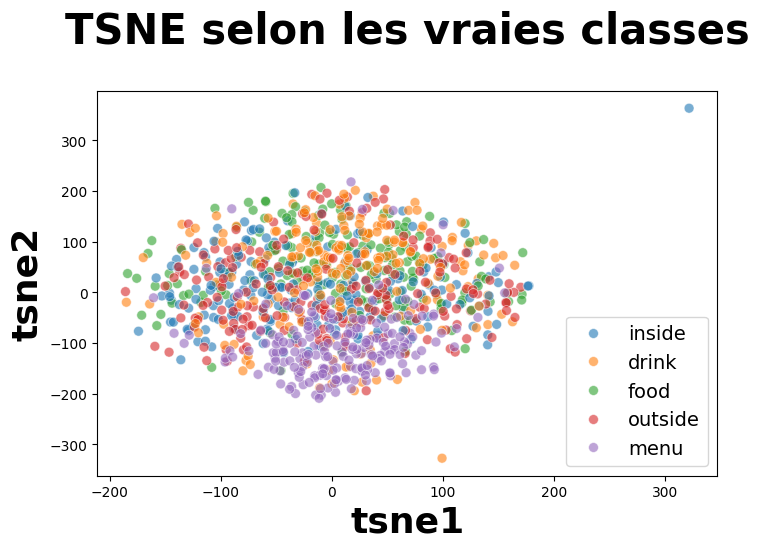

In [15]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [16]:
cls = cluster.KMeans(n_clusters=5, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1000, 5)


In [17]:
# Vérification si ma heatmap correspond au bonnes données
#df_tsne[df_tsne["class"] == "outside"].groupby("cluster").count()

###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters
* Le score ARI de 0.092 reste faible

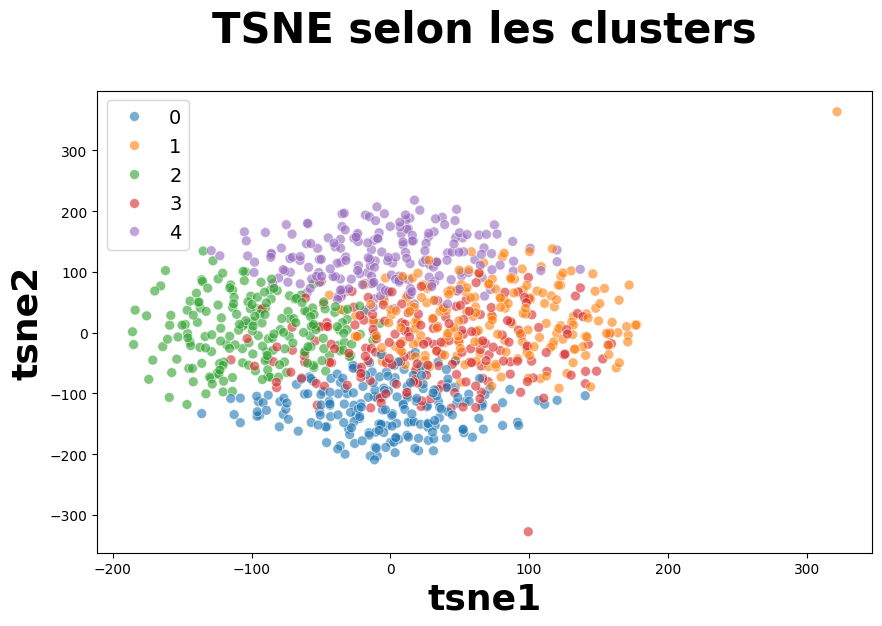

ARI :  0.09203214083406729


In [18]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df_photos_clean["num_label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### Analyse par classes
* On construit la matrice de confusion pour pouvoir créer la heatmap
* On créer la heatmap

In [19]:
# df_tsne.groupby("cluster").count()["class"]

In [20]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
# print(conf_mat)

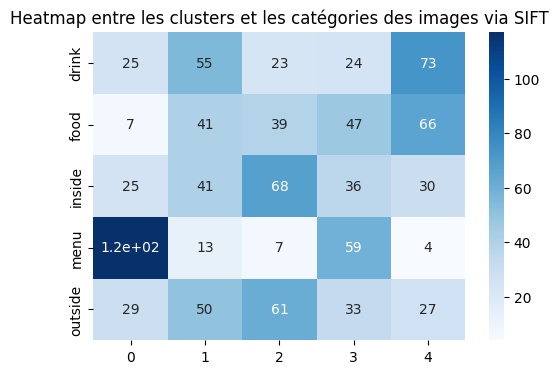

In [21]:
# On observe que la catégorie outside est séparé entre les cluster 1, 2 et 4
# On observe que le cluster 4 est séparé entre la catégorie "inside" et "outside"
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "01234"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.title("Heatmap entre les clusters et les catégories des images via SIFT")
plt.show()

# Extraction des features par un CNN (Réseau neuronal convolutif) pré-entrainé ResNet50

In [22]:
#import tensorflow as tf
#tf.version.VERSION

In [23]:
import tensorflow as tf

# from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
# model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
# model.summary()

# Charger model_resnet50 pré-entraîné sur ImageNet et sans les couches fully-connected
# resnet50 me donne un meilleur score de ahri que le vgg16 0.362 > 0.313
model_resnet50 = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
# model_resnet50.summary()

In [24]:
# Création du dataframe pour le recadrage des images
images_dir = 'yelp_photos/photos'
images_cnn = df_photos_clean[['photo_id','label']]
images_cnn['photo_id'] = images_cnn['photo_id'].astype(str) + '.jpg'
images_cnn


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,photo_id,label
0,zsvj7vloL4L5jhYyPIuVwg.jpg,inside
1,vkr8T0scuJmGVvN2HJelEA.jpg,drink
2,pve7D6NUrafHW3EAORubyw.jpg,food
3,3ROd5PAQ_0OkmoKWVO06ag.jpg,inside
4,foJzmWwl8WlC3xi-QQDRgg.jpg,outside
...,...,...
995,EEcsawYOpKehTKchMnKPRA.jpg,menu
996,ASRHqFuyngOOdnxqfHSgpA.jpg,menu
997,YYlpq7j7rmYaiaTL5rHwLA.jpg,menu
998,GvZ7ErAAtVbJjVnrmXSpWQ.jpg,menu


In [25]:
# Génération des images pour la prédiction par le CNN
image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
image_gen = image_generator.flow_from_dataframe(images_cnn,
                                             images_dir,
                                             x_col='photo_id',
                                             y_col='label', 
                                             target_size=(224, 224),
                                             class_mode=None,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 1000 validated image filenames.


In [26]:
# On génère les prédictions
resnet50_preds = model_resnet50.predict(image_gen, verbose=False)
#resnet50_preds.shape

In [27]:
# Redimensionnement du dataframe
features_cnn_resnet50 = resnet50_preds.reshape(1000,7*7*2048)

## Réductions de dimension

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [28]:
print("Dimensions dataset avant réduction PCA : ", features_cnn_resnet50.shape)
pca_cnn = decomposition.PCA(n_components=0.99)
feat_pca_cnn= pca_cnn.fit_transform(features_cnn_resnet50)
print("Dimensions dataset après réduction PCA : ", feat_pca_cnn.shape)

Dimensions dataset avant réduction PCA :  (1000, 100352)
Dimensions dataset après réduction PCA :  (1000, 952)


### Réduction de dimension T-SNE
* Réduction de dimension en 3 composantes T-SNE pour affichage en 2D et 3D des images

In [29]:
tsne_cnn = manifold.TSNE(n_components=3, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne_cnn = tsne_cnn.fit_transform(feat_pca_cnn)

df_tsne_cnn = pd.DataFrame(X_tsne_cnn[:,0:3], columns=['tsne1', 'tsne2', 'tsne3'])
df_tsne_cnn["class"] = df_photos_clean["label"]
df_tsne_cnn.to_csv('df_tsne_cnn.csv', index=False)
print(df_tsne_cnn.shape)

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


(1000, 4)


## Analyse visuelle : affichage T-SNE selon catégories d'images
* On observe que les catégories d'images sont visibles à l'oeil nu

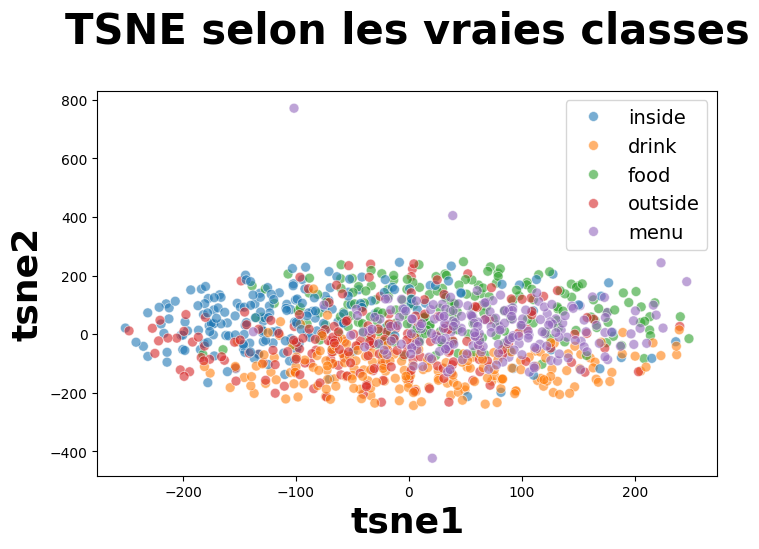

In [30]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_cnn, legend="brief",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [31]:
# Vérification si ma heatmap correspond au bonnes données
#df_tsne_cnn[df_tsne_cnn["class"] == "outside"].groupby("cluster").count()

In [32]:
cls_cnn = cluster.KMeans(n_clusters=5, random_state=6)
cls_cnn.fit(X_tsne_cnn)

df_tsne_cnn["cluster"] = cls_cnn.labels_
print(df_tsne_cnn.shape)

(1000, 5)


In [33]:
df_tsne_cnn

,tsne1,tsne2,tsne3,class,cluster
0,18.828741,165.939240,-118.887848,inside,4
1,152.221451,-69.196297,137.587723,drink,2
2,114.894623,202.732086,74.930153,food,1
3,-173.312515,35.161934,-170.672318,inside,4
4,3.143807,222.472214,-99.589775,outside,4
...,...,...,...,...,...
995,130.172729,5.044213,-55.837502,menu,0
996,-20.786661,119.727600,-13.578608,menu,4
997,29.017756,-20.228062,15.564810,menu,2
998,-45.688660,63.310982,-19.487463,menu,4


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters
* Le score ARI de 0.290 (Satisfaisant pour un apprentissage non supervisé)

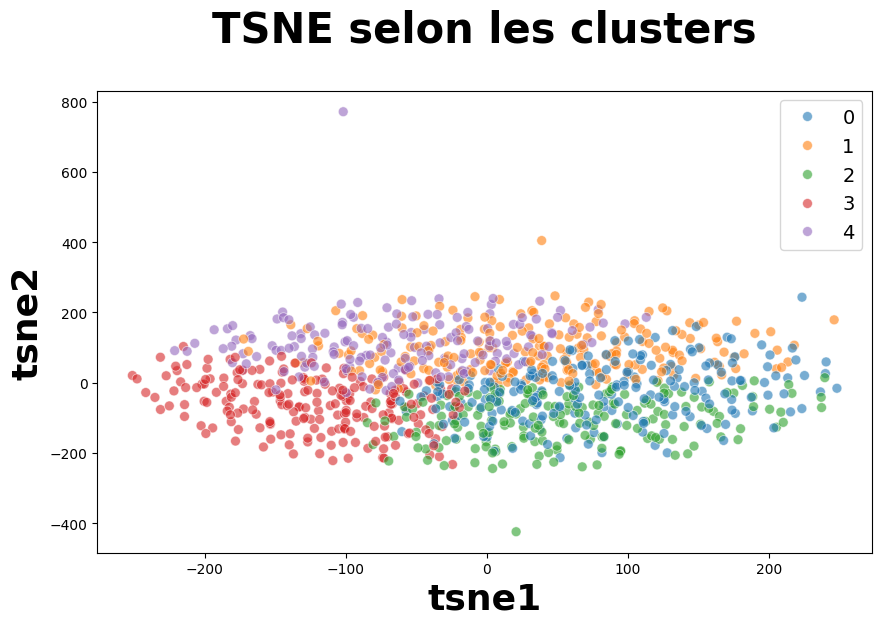

ARI :  0.29081895408801384


In [34]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6,
    data=df_tsne_cnn,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df_photos_clean["num_label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls_cnn.labels_))

### Analyse par classes
* On construit la matrice de confusion pour pouvoir créer la heatmap
* On créer la heatmap

In [35]:
#df_tsne_cnn.groupby("cluster").count()["class"]

In [36]:
conf_mat_cnn = metrics.confusion_matrix(labels, cls_cnn.labels_)
#print(conf_mat_cnn)

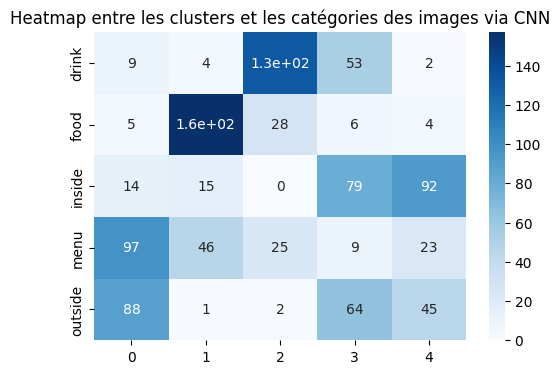

In [37]:
# On observe que la catégorie food est séparé entre le cluster 3 et 4
# On observe que le cluster 0 est séparé entre la catégorie "inside" et "outside"
# La catégorie 'inside n'est pas représenté concretement par un cluster
df_cm_cnn = pd.DataFrame(conf_mat_cnn, index = [label for label in list_labels],
                  columns = [i for i in "01234"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm_cnn, annot=True, cmap="Blues")
plt.title("Heatmap entre les clusters et les catégories des images via CNN")
plt.show()

## Conclusion
* Le score de ahri et les différents résultats sont plus intéressant lorsqu'on utilise le CNN resnet50 que lorsqu'on utilise le modèle SIFT. (0.427 > 0.142)
* On utilise resnet50 au lieu de vgg16 car resnet50 me donne un meilleur score de ahri que le vgg16 (0.427 > 0.142)

# Extraction des features par CLIP (Contrastive Language–Image Pretraining) d'OpenAI

In [38]:
# Charger le modèle CLIP
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

list_labels = ["drink", "food", "inside", "menu", "outside"]

# Fonction pour récupérer les features d'une image et d'un texte
def get_features(image_path, text):
    # Prétraiter l'image
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    # Tokenizer le texte
    text = clip.tokenize([text]).to(device)
    
    # Encoder les features de l'image et du texte
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
    
    return image_features.cpu().numpy().flatten(), text_features.cpu().numpy().flatten()

# Liste pour stocker les features
image_features_list = []
text_features_list = []

# Parcourir le DataFrame et récupérer les features
for idx, row in df_photos_clean.iterrows():
    image_path = f"C:/Users/leoch/Projets Jupyter/Parcours Ingenieur IA/Projet 10/yelp_photos/photos/{row['photo_id']}.jpg"  # Modifiez le chemin selon vos besoins
    text = row['caption']
    image_features, text_features = get_features(image_path, text)
    image_features_list.append(image_features)
    text_features_list.append(text_features)

# Convertir les listes de features en DataFrame ou les enregistrer selon les besoins
image_features_df = pd.DataFrame(image_features_list)
text_features_df = pd.DataFrame(text_features_list)

# Combiner les features des images et des textes
combined_features_clip = pd.concat([image_features_df, text_features_df], axis=1)

# Sauvegarder les features combinées dans un fichier CSV
combined_features_clip.to_csv('combined_features_clip.csv', index=False)

# Afficher les premières lignes du DataFrame combiné
print(combined_features_clip.head())

        0         1         2         3         4         5         6    \
0 -0.154047  0.338725  0.167266  0.301766  0.140646 -0.247271  0.182358   
1 -0.340198  0.512056 -0.226232  0.084487  0.866744 -0.146230 -0.043563   
2 -0.554397  0.192290  0.144578 -0.142631  0.342257  0.145506  0.003446   
3  0.138624  0.142615  0.002507 -0.019970  0.007228 -0.238848 -0.070369   
4  0.273932  0.176721  0.137648 -0.392003  0.352714 -0.246859 -0.011591   

        7         8         9    ...       502       503       504       505  \
0  0.309354 -0.429327 -0.118559  ... -0.097372 -0.061201  0.300147 -0.032329   
1  0.715165 -0.269041  0.203348  ...  0.178475  0.117683 -0.054939  0.462205   
2  0.180747  0.182244  0.299230  ... -0.027445 -0.001292 -0.156072  0.135994   
3  0.885520 -0.698928  0.114203  ... -0.269196  0.365461  0.541934  0.131929   
4  0.597912  0.215711  0.451613  ... -0.221356  0.101254  0.073352 -0.308526   

        506       507       508       509       510       511  
0  0

In [39]:
df_clip = pd.DataFrame(columns=['cluster'])

cls2_clip = cluster.KMeans(n_clusters=5, random_state=6)
cls2_clip.fit(combined_features_clip)

df_clip["cluster"] = cls2_clip.labels_
print(df_clip.shape)

(1000, 1)


In [40]:
# Calcul ARI de similarité catégories images / clusters sans TSNE et ACP
labels = df_photos_clean["num_label"]
print("ARI : ", metrics.adjusted_rand_score(labels, df_clip.cluster))

ARI :  0.5288121564905889


### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [41]:
print("Dimensions dataset avant réduction PCA : ", combined_features_clip.shape)
pca_clip = decomposition.PCA(n_components=0.99)
feat_pca_clip = pca_clip.fit_transform(combined_features_clip)
print("Dimensions dataset après réduction PCA : ", feat_pca_clip.shape)

Dimensions dataset avant réduction PCA :  (1000, 1024)
Dimensions dataset après réduction PCA :  (1000, 628)


### Réduction de dimension T-SNE
* Réduction de dimension en 3 composantes T-SNE pour affichage en 2D et 3D des images

In [42]:
tsne_clip = manifold.TSNE(n_components=3, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne_clip = tsne_clip.fit_transform(feat_pca_clip)

df_tsne_clip = pd.DataFrame(X_tsne_clip[:,0:3], columns=['tsne1', 'tsne2', 'tsne3'])
df_tsne_clip["class"] = df_photos_clean["label"]
df_tsne_clip.to_csv('df_tsne_clip.csv', index=False)

print(df_tsne_clip.shape)

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


(1000, 4)


In [43]:
df_tsne_clip

,tsne1,tsne2,tsne3,class
0,40.110603,-9.488713,17.788416,inside
1,76.029404,-4.772156,-8.010772,drink
2,-46.248722,-99.183640,5.292068,food
3,10.419244,34.046867,-12.492656,inside
4,44.040993,94.809364,-14.146660,outside
...,...,...,...,...
995,6.316749,12.469674,62.267712,menu
996,-60.906712,7.572813,2.757378,menu
997,-103.355103,14.184925,15.628097,menu
998,-59.818649,-25.355921,63.402931,menu


In [44]:
cls_clip = cluster.KMeans(n_clusters=5, random_state=6)
cls_clip.fit(X_tsne_clip)

df_tsne_clip["cluster"] = cls_clip.labels_
print(df_tsne_clip.shape)

(1000, 5)


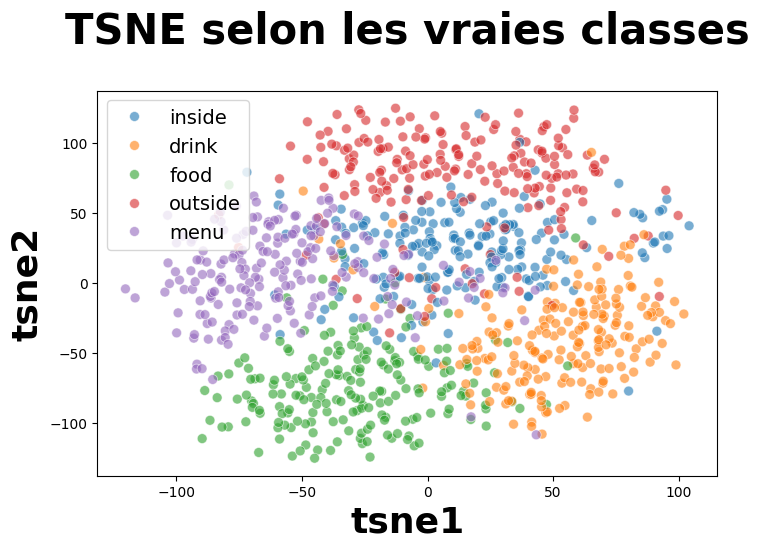

In [45]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_clip, legend="brief",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters
* Le score ARI de 0.599 (Satisfaisant)

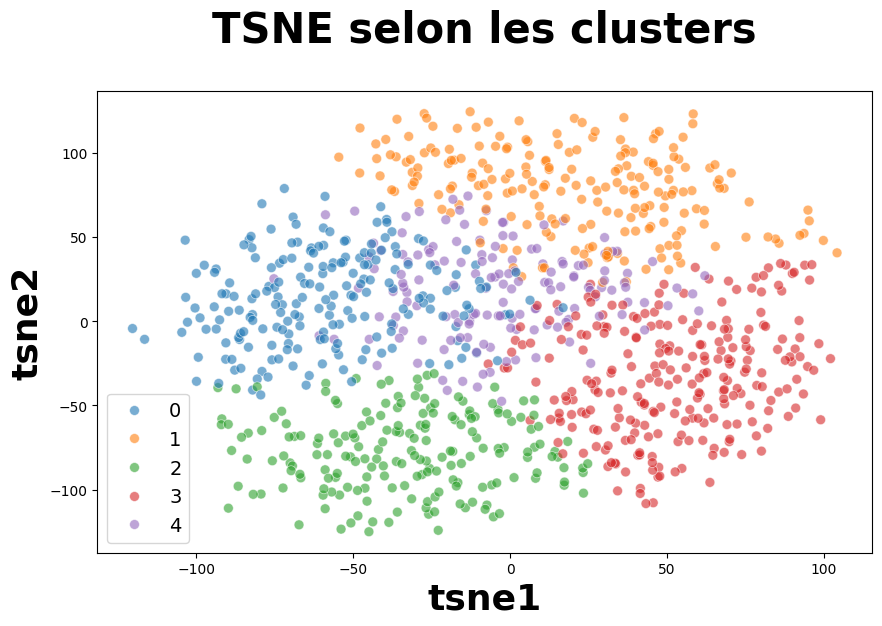

ARI :  0.5995019808908894


In [46]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6,
    data=df_tsne_clip,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df_photos_clean["num_label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls_clip.labels_))

### Analyse par classes
* On construit la matrice de confusion pour pouvoir créer la heatmap
* On créer la heatmap

In [47]:
conf_mat_clip = metrics.confusion_matrix(labels, cls_clip.labels_)
#print(conf_mat_cnn)

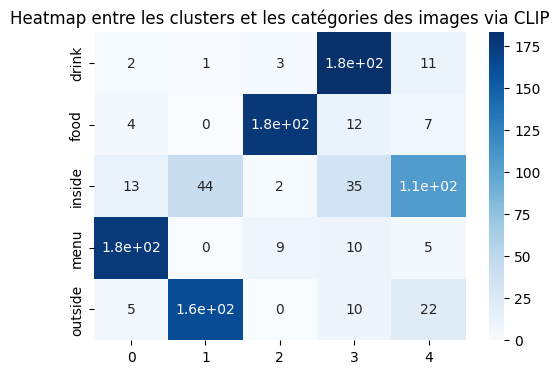

In [48]:
# On observe que la catégorie food est séparé entre le cluster 3 et 4
# On observe que le cluster 0 est séparé entre la catégorie "inside" et "outside"
# La catégorie 'inside n'est pas représenté concretement par un cluster
df_cm_clip = pd.DataFrame(conf_mat_clip, index = [label for label in list_labels],
                  columns = [i for i in "01234"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm_clip, annot=True, cmap="Blues")
plt.title("Heatmap entre les clusters et les catégories des images via CLIP")
plt.show()

## Conclusion
* Le score de ahri et les différents résultats sont plus intéressants lorsqu'on utilise le modèle CLIP OpenAI que lorsqu'on utilise le modèle SIFT. (0.599 > 0.092).
* Le score de ahri et les différents résultats sont plus intéressants lorsqu'on utilise le modèle CLIP OpenAI que lorsqu'on utilise le modèle CNN resnet50. (0.599 > 0.290).

Donc le modèle CLIP OpenAI permet d'avoir de meilleurs résultats qu'un modèle CNN Resnet50 ou SIFT car ce modèle se base sur les images mais aussi sur les descriptions textuelles des images

## Déterminer l'importance locale des features (Shap) 

In [49]:
# Fonction pour prédire les distances aux centres des clusters
def predict_cluster_distances(data):
    # Créez un DataFrame en utilisant les colonnes de df_tsne_clip
    columns = ['tsne1', 'tsne2', 'tsne3']
    data_df = pd.DataFrame(data, columns=columns)
    return cls_clip.transform(data_df)

In [50]:
X_tsne_clip

array([[  40.110603 ,   -9.488713 ,   17.788416 ],
       [  76.0294   ,   -4.772156 ,   -8.010772 ],
       [ -46.248722 ,  -99.18364  ,    5.2920675],
       ...,
       [-103.3551   ,   14.184925 ,   15.628097 ],
       [ -59.81865  ,  -25.35592  ,   63.40293  ],
       [ -72.499405 ,   -5.04191  ,   18.694733 ]], dtype=float32)

X has feature names, but KMeans was fitted without feature names
Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1000 [00:00<?, ?it/s]

X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but 

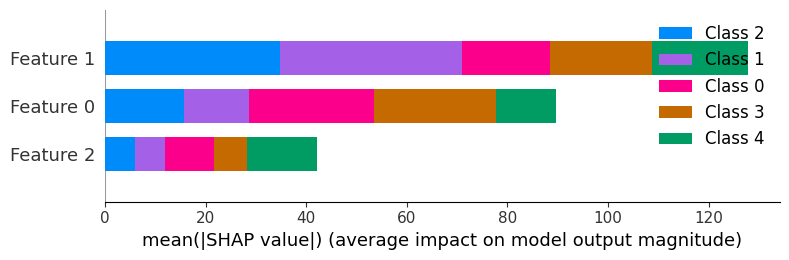

In [52]:
# Utiliser SHAP pour expliquer les distances aux clusters (Modèle CLIP)
explainer_clip = shap.KernelExplainer(predict_cluster_distances, X_tsne_clip)
shap_values_clip = explainer_clip.shap_values(X_tsne_clip)

# Visualiser l'importance des features
shap.summary_plot(shap_values_clip, X_tsne_clip)

X has feature names, but KMeans was fitted without feature names
Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1000 [00:00<?, ?it/s]

X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but 

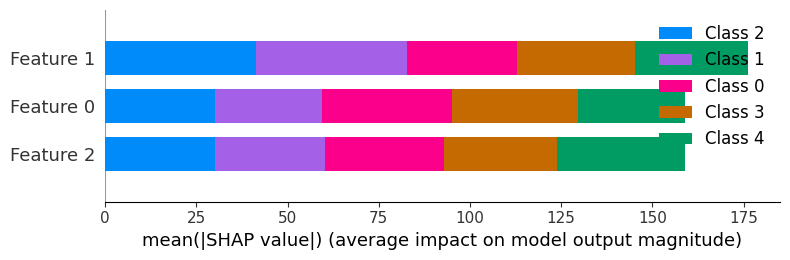

In [53]:
# Utiliser SHAP pour expliquer les distances aux clusters (Modèle CNN)
explainer_cnn = shap.KernelExplainer(predict_cluster_distances, X_tsne_cnn)
shap_values_cnn = explainer_cnn.shap_values(X_tsne_cnn)

# Visualiser l'importance des features
shap.summary_plot(shap_values_cnn, X_tsne_cnn)

X has feature names, but KMeans was fitted without feature names
Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1000 [00:00<?, ?it/s]

X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names
X has feature names, but 

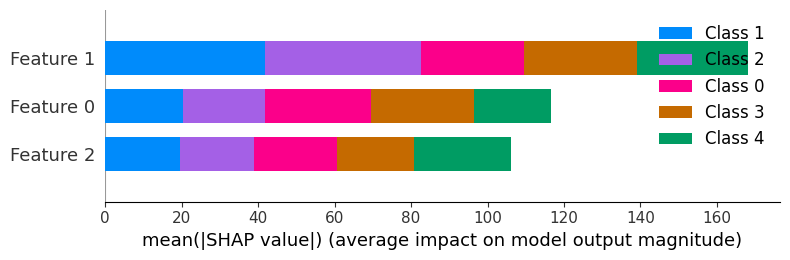

In [54]:
# Utiliser SHAP pour expliquer les distances aux clusters (Modèle SIFT)
explainer_sift = shap.KernelExplainer(predict_cluster_distances, X_tsne)
shap_values_sift = explainer_sift.shap_values(X_tsne)

# Visualiser l'importance des features
shap.summary_plot(shap_values_sift, X_tsne)

In [69]:
# Sauvegarder les valeurs SHAP dans un fichier
with open('shap_values_clip.pkl', 'wb') as f:
    pickle.dump(shap_values_clip, f)
with open('shap_values_cnn.pkl', 'wb') as f:
    pickle.dump(shap_values_cnn, f)
with open('shap_values_sift.pkl', 'wb') as f:
    pickle.dump(shap_values_sift, f)